In [6]:
import numpy as np
import scipy as sc
import csv
import sys, os
import pandas as pd
import scipy.linalg as spl
import matplotlib.pyplot as plt
from opt_utils import *
import grad_utils as model
%matplotlib inline

# Time unit: round

# Time unit: year

In [4]:
def get_nfl_year(directory,year):
    '''
    grouping all rounds in one year into a 2-d array
    '''
    N = 32 # NFL-specific value
    game_matrix = np.zeros((N,N))
    directory = directory + '/' + str(year) + '/'
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".csv"): 
#             print(os.path.join(directory, filename))
            fpath = os.path.join(directory, filename)
            rnd_df = pd.read_csv(fpath)
            pwise_diff = rnd_df.pivot(index='team_ind', columns='team_other_ind',values='diff').values
            pwise_diff[pwise_diff >= 0] = 1
            pwise_diff[pwise_diff < 0] = 0
            pwise_diff[np.isnan(pwise_diff)] = 0
            game_matrix += pwise_diff[0:N,0:N]
        else:
            continue
    return game_matrix

In [7]:
directory = 'E:/Git_Rep/bradley-terry-convexopt/data/nfl'
game_matrix_list = np.array([get_nfl_year(directory,2009 + i) for i in range(8)])

d:\python35\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in greater_equal
d:\python35\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in less


In [8]:
game_matrix_list[1].shape

(32, 32)

## Fit the model with squared l2-penalty

### Fit with small penalty

In [9]:
# optimization parameters
l_penalty = 0.02
max_iter = 1000
ths = 1e-12

# vanilla PGD parameters
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

### Newton

In [13]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2]).reshape((N * T,1))
step_size = 1

# initialize record
objective_nt = [objective_l2_sq(beta, data, l_penalty)]
print("initial objective value: %f"%objective_nt[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2_sq(beta, data, l_penalty)[1:]
    hessian = hess_l2_sq(beta, data, l_penalty)[1:,1:]
    # newton update
    beta[1:] = beta[1:] - step_size * sc.linalg.solve(hessian, gradient)
    
    # objective value
    objective_nt.append(objective_l2_sq(beta, data, l_penalty))
    
    print("%d-th Newton, objective value: %f"%(i+1, objective_nt[-1]))
    if objective_nt[-2] - objective_nt[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 1411.247660
1-th Newton, objective value: 1100.817752
2-th Newton, objective value: 1084.010448
3-th Newton, objective value: 1083.406110
4-th Newton, objective value: 1083.402188
5-th Newton, objective value: 1083.402187
6-th Newton, objective value: 1083.402187
Converged!


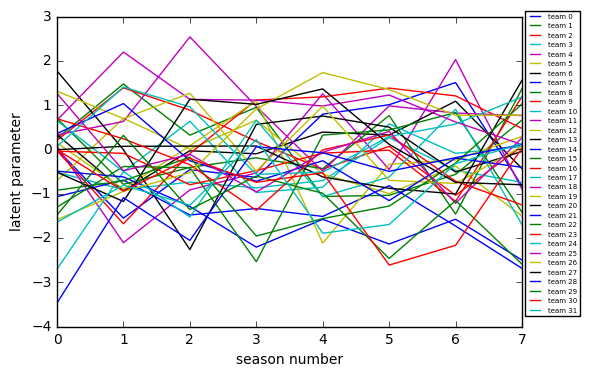

In [14]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 5})

### Fit with large penalty

In [16]:
# optimization parameters
l_penalty = 20
max_iter = 1000
ths = 1e-12

# vanilla PGD parameters
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

### Newton

In [17]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2]).reshape((N * T,1))
step_size = 1

# initialize record
objective_nt = [objective_l2_sq(beta, data, l_penalty)]
print("initial objective value: %f"%objective_nt[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2_sq(beta, data, l_penalty)[1:]
    hessian = hess_l2_sq(beta, data, l_penalty)[1:,1:]
    # newton update
    beta[1:] = beta[1:] - step_size * sc.linalg.solve(hessian, gradient)
    
    # objective value
    objective_nt.append(objective_l2_sq(beta, data, l_penalty))
    
    print("%d-th Newton, objective value: %f"%(i+1, objective_nt[-1]))
    if objective_nt[-2] - objective_nt[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 1411.247660
1-th Newton, objective value: 1289.347563
2-th Newton, objective value: 1288.617182
3-th Newton, objective value: 1288.616714
4-th Newton, objective value: 1288.616714
5-th Newton, objective value: 1288.616714
Converged!


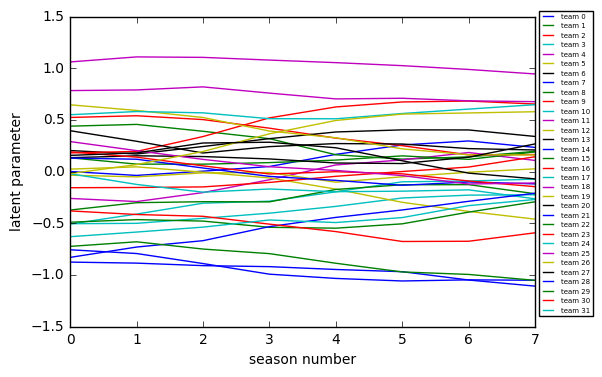

In [18]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 5},ncol = 1)

# L2 penalty

## Sub-gradient Descent with backtracking

In [15]:
# optimization parameters
l_penalty = 0.02
max_iter = 1000
ths = 1e-12
step_size = 1

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

In [16]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2])
nll = model.neg_log_like(beta, data)

# initialize record
objective_gd = [objective_l2(beta, data, l_penalty)]
print("initial objective value: %f"%objective_gd[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2(beta, data, l_penalty).reshape([T,N])
    

    # backtracking line search
    s = step_size
    for j in range(max_back):
        beta_new = beta - s * gradient
        beta_diff = beta_new - beta
        
        nll_new = model.neg_log_like(beta_new, data)
        nll_back = (nll + np.sum(gradient * beta_diff) 
                    + np.sum(np.square(beta_diff)) / (2*s))
        
        if nll_new <= nll_back:
            break
        s *= b
    
    # sub-gradient update
    beta = beta_new
    nll = nll_new
    
    # objective value
    objective_gd.append(objective_l2(beta, data, l_penalty))
    
    print("%d-th GD, objective value: %f"%(i+1, objective_gd[-1]))
    if objective_gd[-2] - objective_gd[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 1411.247660
1-th GD, objective value: 1101.114452
2-th GD, objective value: 1082.209767
3-th GD, objective value: 1079.975105
4-th GD, objective value: 1078.134727
5-th GD, objective value: 1078.034794
6-th GD, objective value: 1077.996808
7-th GD, objective value: 1077.968704
8-th GD, objective value: 1077.958261
9-th GD, objective value: 1077.941447
10-th GD, objective value: 1077.934360
11-th GD, objective value: 1077.928266
12-th GD, objective value: 1077.922935
13-th GD, objective value: 1077.919114
14-th GD, objective value: 1077.909619
15-th GD, objective value: 1077.903203
16-th GD, objective value: 1077.899683
17-th GD, objective value: 1077.893335
18-th GD, objective value: 1077.890576
19-th GD, objective value: 1077.888066
20-th GD, objective value: 1077.885806
21-th GD, objective value: 1077.883943
22-th GD, objective value: 1077.879614
23-th GD, objective value: 1077.876756
24-th GD, objective value: 1077.874776
25-th GD, objective value: 1077.8715

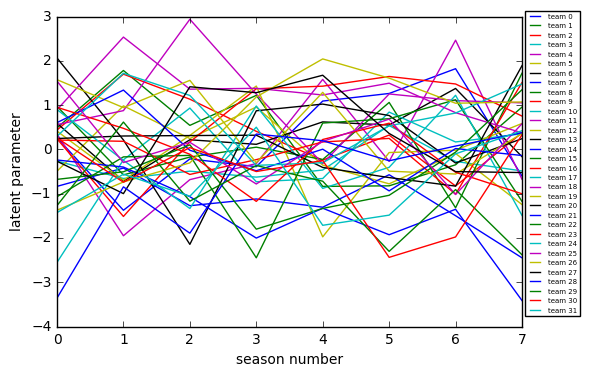

In [18]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 5},ncol = 1)